# Model Training and Evaluation

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import shap
from sklearn.preprocessing import LabelEncoder

In [2]:
# Read the csv file.
df = pd.read_csv('processed.csv', encoding='windows-1255')
df.head()

,Unnamed: 0,Ranking,TV_Show,Channel,Duration,Ranking_Percent,Datetime,Month,Week,Day,Hour,Minute,Day_of_week
0,0,1,האח הגדול 2020,רשת 13,152.0,20.1,2020-01-01 21:12:00,1,1,1,21,12,2
1,1,2,חדשות 12,קשת 12,88.0,14.0,2020-01-01 19:56:00,1,1,1,19,56,2
2,2,3,הצינור,רשת 13,22.0,13.8,2020-01-01 23:43:00,1,1,1,23,43,2
3,3,4,תכנית חיסכון 12,קשת 12,32.0,12.2,2020-01-01 19:21:00,1,1,1,19,21,2
4,4,5,חדשות 13,רשת 13,75.0,11.2,2020-01-01 19:57:00,1,1,1,19,57,2


In [3]:
# Drop unwanted columns for training.
df = df.drop(['Unnamed: 0', 'Datetime'], axis=1)
df.head()

,Ranking,TV_Show,Channel,Duration,Ranking_Percent,Month,Week,Day,Hour,Minute,Day_of_week
0,1,האח הגדול 2020,רשת 13,152.0,20.1,1,1,1,21,12,2
1,2,חדשות 12,קשת 12,88.0,14.0,1,1,1,19,56,2
2,3,הצינור,רשת 13,22.0,13.8,1,1,1,23,43,2
3,4,תכנית חיסכון 12,קשת 12,32.0,12.2,1,1,1,19,21,2
4,5,חדשות 13,רשת 13,75.0,11.2,1,1,1,19,57,2


## Label Encoding

In [4]:
# Perform label encoding on the categorical variables, the model we chose can handle them automatically but we need it for the SHAP algorithm.
encoders = {}

for column in df.select_dtypes(include=[object]):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    encoders[column] = le


In [5]:
encoders['TV_Show'].classes_

array(['MKR המטבח המנצח - עונה 2', 'MKR המטבח המנצח - עונה 2 - שלב הבתים',
       'MKR המטבח המנצח - עונה 2 ש.ח', 'MKR המטבח המנצח VIP',
       'MKR המטבח המנצח VIP עונה 2', 'אבודים עונה 13', 'אבודים עונה 15',
       'אהבה גדולה מהחיים', 'אהבה חדשה', 'אהבה חדשה עונה 2',
       'אהבה חדשה עונה 2 ש.ח', 'אהבה חדשה עונה 3', 'אהרוני 2 גו ש.ח',
       'אוכל מהבית ש.ח', 'אולפן שישי - הכתבות', 'אולפן שישי 12',
       'אולפן שישי 12 - הכתבות', 'אולפן שישי 12 - מהדורה מוקדמת',
       'אולפן שישי 12 ש.ח', "אופירה וברקוביץ' - עונה 3",
       "אופירה וברקוביץ' - עונה 3 ש.ח", 'אזור בחירה', 'אחד למיליון',
       'אחד למיליון ש.ח', 'איזה צחוק עם אבי נוסבאום ש.ח',
       'אל תפילו את המיליון עונה 3', 'אל תפילו את המיליון עונה 3 ש.ח',
       'אלמוג בשישי', 'אמבוש אקסטרים', 'אמבוש אקסטרים ש.ח',
       'אנשים - עונה 2023', 'אנשים עונה 16',
       'אקס פקטור עונה 4 לאירוויזיון', 'אקס פקטור עונה 4 לאירוויזיון ש.ח',
       'ארץ נהדרת לקט ש.ח', 'ארץ נהדרת עונה 17', 'ארץ נהדרת עונה 17 ש.ח',
       'ארץ נהדרת ע

## Train-Test Split

In [6]:
# Seperate the dependent variable from the independent variables.
y = df['Ranking_Percent']
X = df.drop(['Ranking_Percent'], axis=1)

In [7]:
# Split the data to train and test sets and making sure to have an equal representation of all the tv shows in the datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=X['TV_Show'], random_state=42)

## Baseline

In [8]:
# Train a baseline model.
model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature='auto')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 17345, number of used features: 10
[LightGBM] [Info] Start training from score 6.742923


LGBMRegressor()

In [9]:
# Get the predictions.
y_pred = model.predict(X_test)

In [10]:
# Evaluation metrics.
rmse = mean_squared_error(y_test, y_pred, squared=False) # Root mean squared error.
mae = mean_absolute_error(y_test, y_pred) # Mean Absolute Error
r2 = r2_score(y_test, y_pred) # R2 Score

In [11]:
rmse

1.0757666638791799

In [12]:
mae

0.7646030085992425

In [13]:
r2

0.9174715439767357

## Hyperparameter Optimization

In [15]:
# Search spaces for Bayesian Search.
search_spaces = {
    'boosting_type': Categorical(['gbdt', 'dart']),
    'num_leaves': Integer(20, 200),
    'learning_rate': Real(0.01, 0.2, 'log-uniform'),
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(5, 50),
    'min_data_in_leaf': Integer(10, 300),
    'max_bin': Integer(100, 400),
    'feature_fraction': Real(0.6, 1.0, 'uniform'),
    'bagging_fraction': Real(0.6, 1.0, 'uniform'),
    'bagging_freq': Integer(0, 20),
    'min_sum_hessian_in_leaf': Real(0, 10),
    'lambda_l1': Real(1e-10, 100, 'log-uniform'),
    'lambda_l2': Real(1e-10, 100, 'log-uniform'),
    'min_gain_to_split': Real(0, 0.7),
}


In [16]:
# Optimization.
lgbm = lgb.LGBMRegressor(objective='regression', metric='mae')

opt = BayesSearchCV(
    lgbm,
    search_spaces,
    n_iter=50,
    cv=5,
    n_jobs=-1
)

opt.fit(X_train, y_train, categorical_feature='auto')

print("Best parameters found: ", opt.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.4324473183830886, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.4324473183830886
[LightGBM] [Warning] lambda_l1 is set=1e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-10
[LightGBM] [Warning] lambda_l2 is set=1e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1e-10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning]

In [17]:
# Training a regressor with the best hyperparameters.
best = lgb.LGBMRegressor(**opt.best_params_)
best.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.4324473183830886, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.4324473183830886
[LightGBM] [Warning] lambda_l1 is set=1e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-10
[LightGBM] [Warning] lambda_l2 is set=1e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1e-10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning]

LGBMRegressor(bagging_fraction=1.0, bagging_freq=0, feature_fraction=1.0,
              lambda_l1=1e-10, lambda_l2=1e-10, learning_rate=0.2, max_bin=400,
              max_depth=50, min_data_in_leaf=10, min_gain_to_split=0.0,
              min_sum_hessian_in_leaf=3.4324473183830886, n_estimators=1000,
              num_leaves=20)

## Evaluation

In [18]:
# Function to print the evaluation metrics.
def get_scores(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'RMSE: {rmse}\n MAE: {mae}\n R2: {r2}')

In [19]:
# Training set evaluation.
y_pred_train = best.predict(X_train)
get_scores(y_train, y_pred_train)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.4324473183830886, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.4324473183830886
[LightGBM] [Warning] lambda_l1 is set=1e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-10
[LightGBM] [Warning] lambda_l2 is set=1e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1e-10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
RMSE: 0.399840726534

In [20]:
# Test set evaluation.
y_pred_test = best.predict(X_test)
get_scores(y_test, y_pred_test)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.4324473183830886, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.4324473183830886
[LightGBM] [Warning] lambda_l1 is set=1e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-10
[LightGBM] [Warning] lambda_l2 is set=1e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1e-10
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
RMSE: 0.875084371655

In [21]:
# Create a SHAP  tree explainer instance, because LGBM is a tree based algorithm.
explainer = shap.TreeExplainer(best)

# Calculate SHAP values.
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values for the first instance
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

In [22]:
# Get the TV show label.
X_test['TV_Show'].iloc[0]

144

In [23]:
# Get the TV show name.
encoders['TV_Show'].classes_[144]

'הצינור'

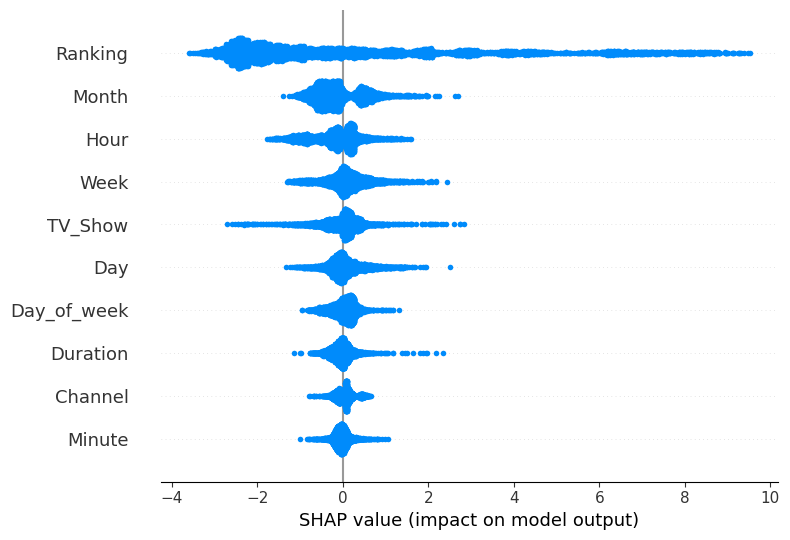

In [24]:
# A SHAP summary plot showing the impact of every feature on the outcome.
shap.summary_plot(shap_values, X.columns)